<a href="https://colab.research.google.com/github/hrushikeshsahu19/Face-Emotion-Detection-/blob/main/face_emotion_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/AlmaBetter/Cohort Aravali/Module 7/Week 2/fer2013.csv')

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [ ]:
data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [ ]:
list(data.columns)

['emotion', 'pixels', 'Usage']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
data['emotion'].value_counts().reset_index()

,index,emotion
0,3,8989
1,6,6198
2,4,6077
3,2,5121
4,0,4953
5,5,4002
6,1,547


In [ ]:
data['Usage'].value_counts().reset_index()

,index,Usage
0,Training,28709
1,PrivateTest,3589
2,PublicTest,3589


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


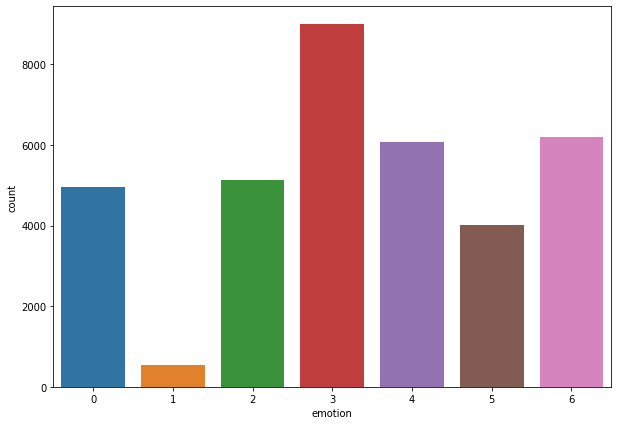

In [ ]:
plt.figure(figsize=(10,7))
sns.countplot(data['emotion'])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

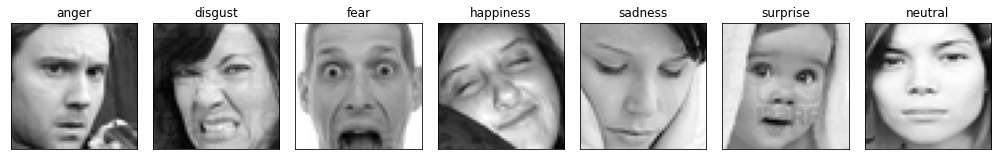

In [ ]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(data.emotion.unique()):
    for j in range(1):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px , cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [ ]:
emotions={0:'Angry' , 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise',6: 'Neutral'}

In [ ]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [ ]:
train_image_array, train_image_label = prepare_data(data[data['Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data['Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data['Usage']=='PublicTest'])

In [ ]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [ ]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [ ]:
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(80, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

In [ ]:
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number])
    axs[1].grid()
    
    plt.show()

In [ ]:
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index())
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

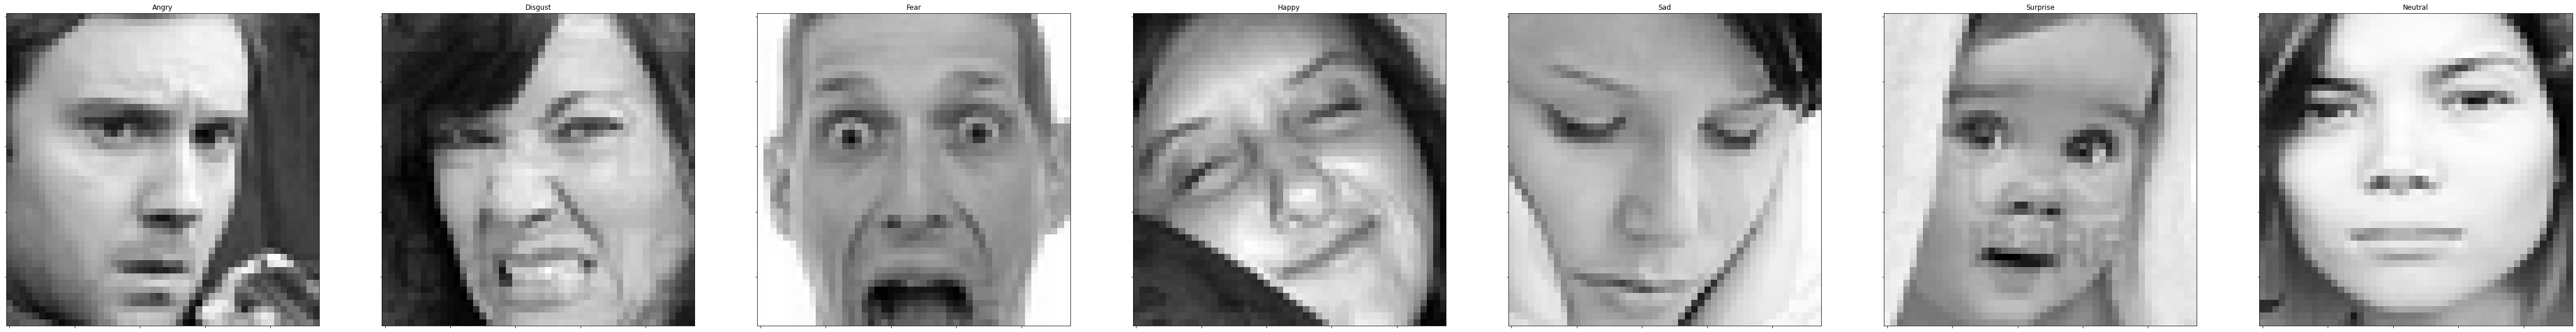

In [ ]:
plot_all_emotions()

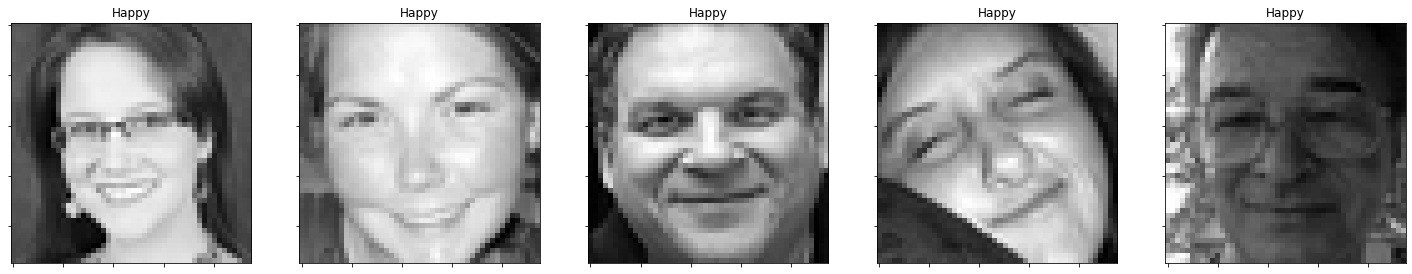

In [ ]:
plot_examples(3)

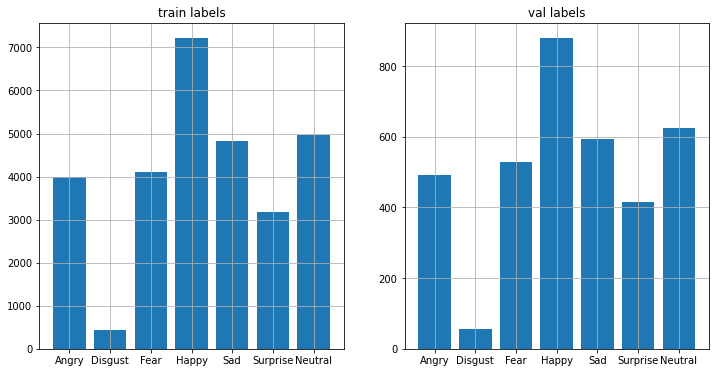

In [ ]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [ ]:
class_weight = dict(zip(range(0, 7), (((data[data['Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data['Usage']=='Training']['emotion'])).tolist()))

In [ ]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

In [ ]:
model=models.Sequential()
model.add(Conv2D(32, (3, 3), padding="same", activation="relu",input_shape=(48, 48, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       204928    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 64)         

In [ ]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=30,
                    batch_size=64)

Epoch 1/30
449/449 [==============================] - 212s 471ms/step - loss: 0.2806 - accuracy: 0.2866 - val_loss: 1.5268 - val_accuracy: 0.4349
Epoch 2/30
449/449 [==============================] - 211s 470ms/step - loss: 0.2214 - accuracy: 0.4509 - val_loss: 1.3986 - val_accuracy: 0.4915
Epoch 3/30
449/449 [==============================] - 213s 474ms/step - loss: 0.1934 - accuracy: 0.5182 - val_loss: 1.2632 - val_accuracy: 0.5333
Epoch 4/30
449/449 [==============================] - 213s 475ms/step - loss: 0.1786 - accuracy: 0.5522 - val_loss: 1.2728 - val_accuracy: 0.5274
Epoch 5/30
449/449 [==============================] - 210s 468ms/step - loss: 0.1631 - accuracy: 0.5959 - val_loss: 1.1971 - val_accuracy: 0.5520
Epoch 6/30
449/449 [==============================] - 209s 465ms/step - loss: 0.1485 - accuracy: 0.6279 - val_loss: 1.1822 - val_accuracy: 0.5692
Epoch 7/30
449/449 [==============================] - 210s 467ms/step - loss: 0.1336 - accuracy: 0.6672 - val_loss: 1.2298 -

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 7s 66ms/step - loss: 3.5324 - accuracy: 0.5500
test caccuracy: 0.5500139594078064


In [ ]:
pred_test_labels = model.predict(test_images)

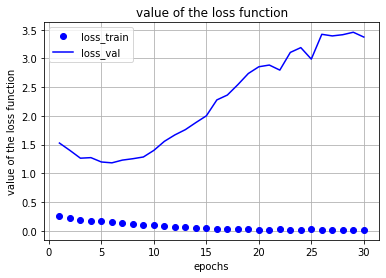

In [ ]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

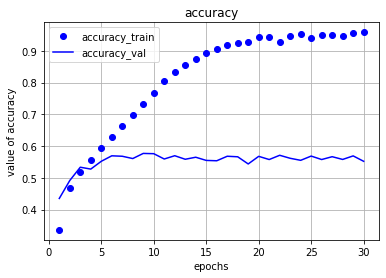

In [ ]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

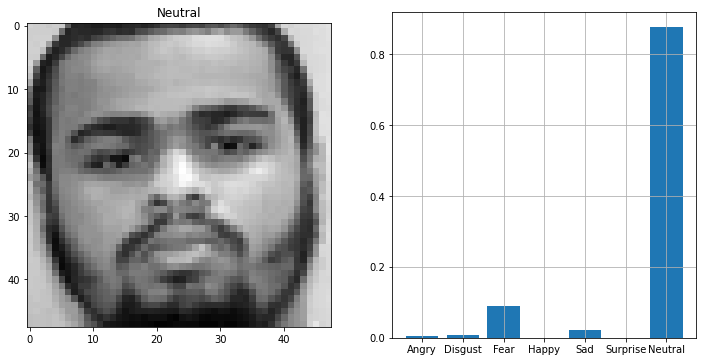

In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 106)

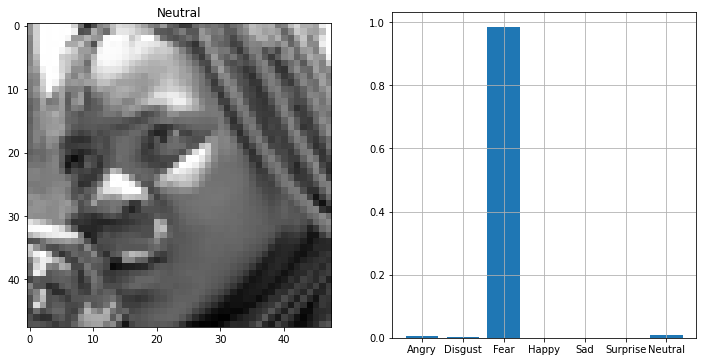

In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 69)

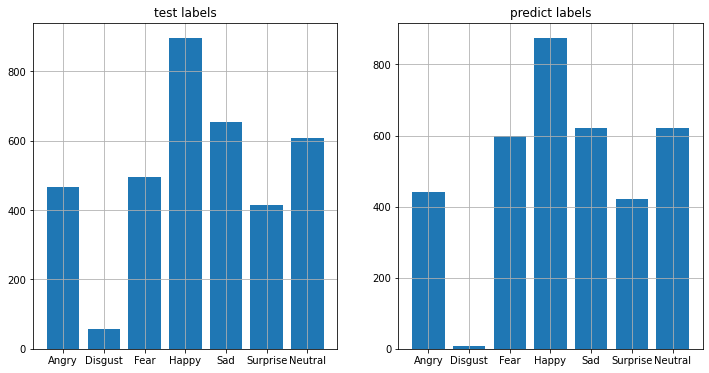

In [ ]:
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

In [ ]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

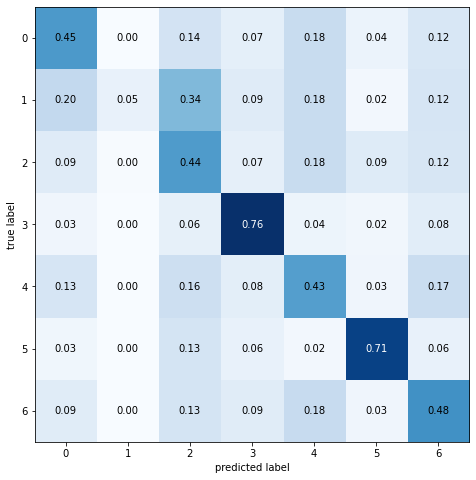

In [ ]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                #class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()